# STEP 3: Analyze candidates and select optimal partition

This is the final step where the output partitions are collected. From the collected partitions the ones that score best in terms of highest spatial precision and fewest missing values are selected.

# Packages

In [1]:
import itertools
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm
# from itertools import chain

from sqr.core.network import partition_surjective
from sqr.core.scoring import partition_score, get_undominated
from sqr.core.shape import  make_gdf_square_data
from sqr.miscellaneous import read_parse_mun
from sqr.core.config import cell_label, years

%matplotlib inline

# Load data 

#### Municipal data 

This data consists of the shape files for municipalities and muncipality data parsed to have square net information. 

In [2]:
gdf_kommuner = read_parse_mun()

#### Preprocessed data 

This data consists of the output from running 'Step 1: run assignments.'

In [3]:
other = 'data/temp_from_other/'
main = 'data/'
pareto = 'data/pareto/'

othernames = {'candidates_sub.hdf':['candidates_sub_aws.hdf','candidates_sub_mac.hdf','candidates_sub_oko4.hdf'],
              'candidates.hdf':['candidates_aws.hdf']}

filenames = {'candidates.hdf':['pareto.hdf','parsed/sqr_mun.hdf'], 
             'candidates_sub.hdf':['pareto_sub.hdf','parsed/sqr_mun_sub.hdf']}


### Merge multiple sources (optional)
If running the computation across multiple machines then various files can be merged. The code below may be helpful.

In [4]:
# def attemp_read(in_file, input_key):
#     try:
#         return pd.read_hdf(in_file, key=input_key)
#     except:
#         return pd.DataFrame()

In [5]:
# # list of files with output
# candidate files = 'candidates.hdf', 'candidates_sub.hdf'

# for filename in ['candidates.hdf']:
    
    
#     out_file = main+filename
    
#     in_files = [other+f for f in othernames[filename]]
#     input_keys = list(set(chain(*[pd.HDFStore(in_file).keys() for in_file in in_files])))


#     for input_key in input_keys:    
#         in_list = [attemp_read(f, input_key) for f in in_files]    
#         input_df = pd.concat(in_list)
        
#         try:
#             existing = pd.read_hdf(out_file, key=input_key)
#             out = pd\
#                     .concat([input_df, existing])\
#                     .drop_duplicates(subset='finish_ts')
#         except:
#             out = input_df
        
#         out.to_hdf(out_file, key=input_key)

# Select pareto

Compute Pareto frontier

In [6]:
for filename in ['candidates.hdf','candidates_sub.hdf']:
    
    in_file = main+filename
    out_file = main+filenames[filename][0]
    
    datastore = pd.HDFStore(in_file)
    datakeys = list(datastore.keys())
    datastore.close()
    
    for input_key in datakeys:
        print(input_key, out_file)
        input_df = pd.read_hdf(in_file, key=input_key)
        input_df = input_df.reset_index(drop=True)
        
        if input_df.shape[0]>1:
            out = get_undominated(input_df)
        else:
            out = input_df
        
        out.to_hdf(out_file, key=input_key)

/munidx219 data/pareto.hdf
/munidx222 data/pareto.hdf
/munidx250 data/pareto.hdf
/munidx251 data/pareto.hdf
/munidx290 data/pareto.hdf


# Choose best partitions

In [8]:
def chain(l):
    return list(itertools.chain(*l))

Load populations

In [22]:
# datastore = pd.HDFStore(mun_file, 'r')

In [7]:
mun_pers = {}
mun_indices = {}

in_file = main+'candidates_sub.hdf'
mun_file = main+'parsed/sqr_mun_sub.hdf'

datastore = pd.HDFStore(in_file, mode='r')
datakeys = list(datastore.keys())
datastore.close()

for input_key in datakeys:
    idx = input_key[7:]
    input_df = pd.read_hdf(in_file, key=input_key, mode='r')
    mun_df = pd.read_hdf(mun_file, key='sqidx'+idx)

    mun_pers[idx] = mun_df.minimum_pers.sum()
    mun_indices[idx] = mun_df[cell_label].to_dict()
    
mun_file = main+'parsed/sqr_mun.hdf'    
datastore = pd.HDFStore(mun_file)
datakeys = list(datastore.keys())
datastore.close()
    
for input_key in datakeys:
    idx = input_key[6:]
    datastore = pd.HDFStore(mun_file, mode='r')
    mun_df = pd.read_hdf(mun_file, key=input_key, mode='r')
    mun_pers[idx] = mun_df.minimum_pers.sum()
    mun_indices[idx] = mun_df[cell_label].to_dict()

Load optimal partition mun-level

In [9]:
in_file = main+'pareto.hdf'
datastore = pd.HDFStore(in_file)
datakeys = list(datastore.keys())
datastore.close()


pareto = pd.concat([pd.read_hdf(in_file, k) for k in datakeys]).reset_index()
pareto.mun_idx = pareto.mun_idx.astype(int).astype(str)
pareto['score'] = pareto.apply(lambda row: partition_score(row.weighted_dist, 
                                                           row.count_nonzero_null, 
                                                           mun_pers[row.mun_idx]), 
                               axis=1)
optimals_idx = pareto.groupby('mun_idx').score.idxmax()
optimals = pareto.loc[optimals_idx]
optimals.partition = optimals.partition.apply(json.loads)

Load optimal partition sub mun-level

In [12]:
in_file = main+'pareto_sub.hdf'
datastore = pd.HDFStore(in_file)
datakeys = list(datastore.keys())
datastore.close()

if datakeys:
    
    
    pareto_sub = pd.concat([pd.read_hdf(in_file, k) for k in datakeys]).reset_index()
    pareto_sub['score'] = pareto_sub\
                            .apply(lambda row: partition_score(row.weighted_dist, 
                                                               row.count_nonzero_null, 
                                                               mun_pers[row.mun_idx]),axis=1)
    
    optimals_idx_sub = pareto_sub.groupby('mun_idx').score.idxmax()
    
    optimals_sub = pareto_sub.loc[optimals_idx_sub.values].copy()
    optimals_sub['pop_count'] = optimals_sub.mun_idx.apply(lambda m: mun_pers[m])
    optimals_sub['mun'] = optimals_sub.mun_idx.apply(lambda s: s.split('_')[0])
    optimals_sub.partition = optimals_sub.partition.apply(json.loads)
    
    # remove køge
    # optimals_sub = optimals_sub[~(optimals_sub['mun']=='163')]
    
    gb_idx = optimals_sub.groupby('mun')
    pop_sum = gb_idx.pop_count.sum()
    na_sum = gb_idx.pers_nonzero_null.sum()
    w_dist = gb_idx.apply(lambda g: (g.weighted_dist*g.pop_count).sum()/g.pop_count.sum())
    partitions = gb_idx.partition.apply(chain)
    
    
    optimals_sub_merg = pd.concat([na_sum,
                                   pop_sum,
                                   w_dist.rename('weighted_dist'),
                                   partitions.rename('partition')],axis=1)
    
    optimals_sub_merg['score'] = \
        optimals_sub_merg.apply(lambda row: partition_score(row.weighted_dist, 
                                                        row.pers_nonzero_null, 
                                                        row.pop_count),axis=1)
else:
    optimals_sub_merg = pd.DataFrame(columns=optimals.columns)

Comparison of partitions

In [13]:
merge_cols = ['score','partition','pers_nonzero_null','weighted_dist']
opt_mun = optimals.set_index('mun_idx')[merge_cols]
opt_sub = optimals_sub_merg[merge_cols]                              

merge = opt_mun.merge(opt_sub, how='outer', left_index=True,right_index=True).copy()
merge[['score_x','score_y']] = merge[['score_x','score_y']].fillna(-1)

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_19655/3700851406.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge[['score_x','score_y']] = merge[['score_x','score_y']].fillna(-1)


In [14]:
def get_label(mun_idx, idx):
    return mun_indices[mun_idx][idx]

def get_labels(mun_idx, partition):
    return [[get_label(mun_idx,i) for i in g] for g in partition]

Select maximal scoring partitoin

In [15]:
optimal_indices = merge.apply(lambda row: row.partition_x if row.score_x>row.score_y else row.partition_y, axis=1)

optimal_labels =  optimal_indices\
                    .reset_index()\
                    .rename(columns={'index':'mun_idx',0:'partition'})\
                    .apply(lambda row: get_labels(str(row.mun_idx),row.partition),axis=1)

optimal_labels.index = optimal_indices.index.to_series().astype(int)
optimal_labels.sort_index(inplace=True)            
            
optimal_labels_one = list(itertools.chain(*optimal_labels.tolist()))

In [16]:
os.makedirs('data/output_final/', exist_ok=True)

with open ('data/output_final/partition.json', 'w') as f:
    f.write(json.dumps(optimal_labels_one))

# Analyze optimal partition

In [17]:
# optimal_miss = merge.apply(lambda row: row.pop_nonzero_null_x if row.score_x>row.score_y else row.pop_nonzero_null_y, axis=1)
# optimal_dist = merge.apply(lambda row: row.weighted_dist_x if row.score_x>row.score_y else row.weighted_dist_y, axis=1)

# optimal_stat = pd\
#                 .concat([optimal_miss,pd.Series(mun_pop),optimal_dist],axis=1)\
#                 .dropna()\
#                 .rename(columns={0:'miss',1:'total',2:'dist'})
            
# optimal_stat.index = optimal_stat.index.to_series().astype(int)

# optimal_stat.sort_index().to_csv('data/output_final/statistics.csv')

Check no duplicated

In [18]:
assignment_opt = pd.DataFrame([(i,j) for i,p in enumerate(optimal_labels_one) for j in p],
                              columns=['partition',cell_label])
is_assigned = list(itertools.chain(*optimal_labels_one))
is_assigned_ser = pd.Series(is_assigned)
is_assigned_ser.duplicated().sum()

0

Count population in partitions

In [19]:
distribution = {'hh':{}, 'pers':{}}
for label in 'hh', 'pers':

    pop_data = pd.read_hdf('data/parsed/KN100m_pop.hdf', key=label)

    assignment = dict([(i,g_idx) for g_idx,g in enumerate(optimal_labels_one) for i in g])
    pop_type_assign = pop_data.set_index(cell_label).join(pd.Series(assignment,name='assignment'))
    pop_type_assign = pop_type_assign[pop_type_assign.assignment.notnull()]
    
    distribution[label] = \
        pop_type_assign\
            .groupby('assignment')\
            .apply(lambda g: g[years].dropna(how='all',axis=1).sum(axis=0).min())

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_19655/1496292251.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[years].dropna(how='all',axis=1).sum(axis=0).min())
/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_19655/1496292251.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[years].dropna(how='all',axis=1).sum(axis=0).min())


Verify population minimums

In [20]:
assert(min(distribution['pers'].min()>=100, distribution['hh'].min()>=50))

Make histograms for number of persons and households in the final partitions

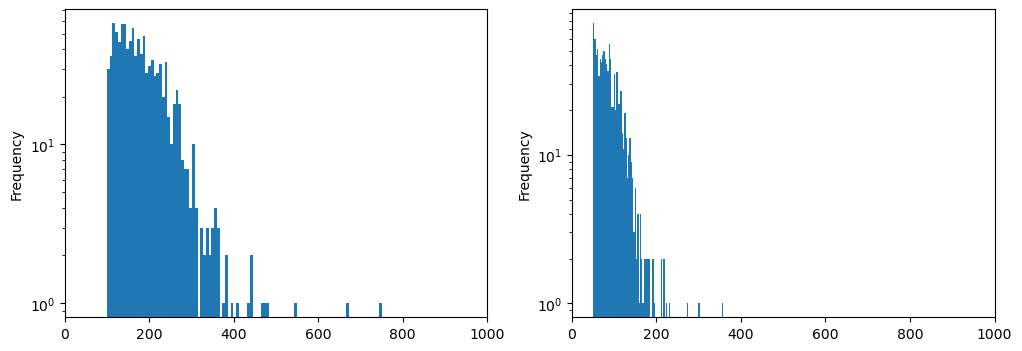

In [30]:
f,ax = plt.subplots(1,2, figsize=(12,4))
distribution['pers'].pipe(lambda s: s[s<2000]).plot.hist(bins=100,log=True, ax=ax[0])
distribution['hh'].pipe(lambda s: s[s<2000]).plot.hist(bins=100,log=True, ax=ax[1])
for i in range(2):
    ax_ = ax[i]
    ax_.set_xlim(0,1000)

Count unassigned population for each year

In [31]:
from sqr.core.config import mean_cols, minimum_cols

info = []
for idx, row in gdf_kommuner.iterrows():        
    info += [pd.read_hdf(mun_file, key=f'sqidx{idx}').assign(KOMNAVN=row.KOMNAVN)]
kominfo = pd.concat(info)

In [32]:
kominfo[~kominfo[cell_label].isin(is_assigned)]\
.groupby(['KOMNAVN'])\
[mean_cols+minimum_cols]\
.agg(['sum', 'mean'])

mean_pers           mean_hh           minimum_pers           \
                      sum      mean     sum      mean          sum     mean   
KOMNAVN                                                                       
Aabenraa              0.0       NaN     0.0       NaN          0.0      NaN   
Aalborg               0.0       NaN     0.0       NaN          0.0      NaN   
Aarhus                0.0       NaN     0.0       NaN          0.0      NaN   
Albertslund         149.7  2.234328    74.4  1.110448         28.0  0.41791   
Allerød               0.0       NaN     0.0       NaN          0.0      NaN   
...                   ...       ...     ...       ...          ...      ...   
Vejle                 0.0       NaN     0.0       NaN          0.0      NaN   
Vesthimmerlands       0.0       NaN     0.0       NaN          0.0      NaN   
Viborg                0.0       NaN     0.0       NaN          0.0      NaN   
Vordingborg           0.0       NaN     0.0       NaN          0.0      NaN   
Ærø                   0.0       NaN     0.0       NaN          0.0      NaN   

                minimum_hh            
                       sum      mean  
KOMNAVN                               
Aabenraa               0.0       NaN  
Aalborg                0.0       NaN  
Aarhus                 0.0       NaN  
Albertslund            4.0  0.059701  
Allerød                0.0       NaN  
...                    ...       ...  
Vejle                  0.0       NaN  
Vesthimmerlands        0.0       NaN  
Viborg                 0.0       NaN  
Vordingborg            0.0       NaN  
Ærø                    0.0       NaN  

[99 rows x 8 columns]

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_19655/3251676684.py:1: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  gdf_k = make_gdf_square_data(kominfo[kominfo.KOMNAVN=='Frederiksberg'])


<Axes: >

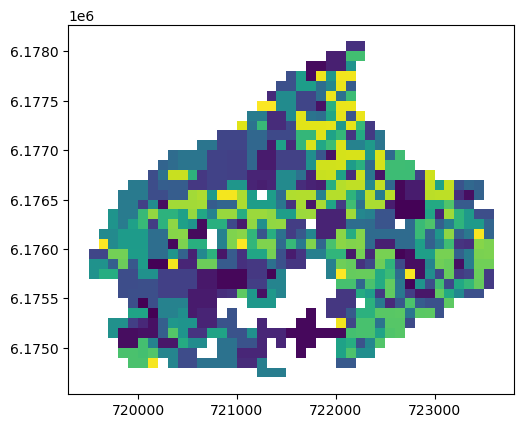

In [33]:
gdf_k = make_gdf_square_data(kominfo[kominfo.KOMNAVN=='Frederiksberg'])
gdf_k.merge(assignment_opt).plot(column='partition')

In [34]:
kominfo[~kominfo[cell_label].isin(is_assigned)]\
.groupby(['KOMNAVN'])\
[mean_cols+minimum_cols]\
.agg(['sum', 'mean'])

mean_pers           mean_hh           minimum_pers           \
                      sum      mean     sum      mean          sum     mean   
KOMNAVN                                                                       
Aabenraa              0.0       NaN     0.0       NaN          0.0      NaN   
Aalborg               0.0       NaN     0.0       NaN          0.0      NaN   
Aarhus                0.0       NaN     0.0       NaN          0.0      NaN   
Albertslund         149.7  2.234328    74.4  1.110448         28.0  0.41791   
Allerød               0.0       NaN     0.0       NaN          0.0      NaN   
...                   ...       ...     ...       ...          ...      ...   
Vejle                 0.0       NaN     0.0       NaN          0.0      NaN   
Vesthimmerlands       0.0       NaN     0.0       NaN          0.0      NaN   
Viborg                0.0       NaN     0.0       NaN          0.0      NaN   
Vordingborg           0.0       NaN     0.0       NaN          0.0      NaN   
Ærø                   0.0       NaN     0.0       NaN          0.0      NaN   

                minimum_hh            
                       sum      mean  
KOMNAVN                               
Aabenraa               0.0       NaN  
Aalborg                0.0       NaN  
Aarhus                 0.0       NaN  
Albertslund            4.0  0.059701  
Allerød                0.0       NaN  
...                    ...       ...  
Vejle                  0.0       NaN  
Vesthimmerlands        0.0       NaN  
Viborg                 0.0       NaN  
Vordingborg            0.0       NaN  
Ærø                    0.0       NaN  

[99 rows x 8 columns]

Distribution of unassigned persons and households

DDKNm100
100m_61731_7087    7166
100m_61746_7214      73
100m_61748_7198      66
100m_61224_8640      59
100m_61214_8635      53
dtype: int64

hh
DDKNm100
100m_61731_7087    7166
100m_61746_7214      73
100m_61748_7198      66
100m_61224_8640      59
100m_61214_8635      53
dtype: int64


pers
DDKNm100
100m_61731_7087    14610
100m_61746_7214      158
100m_61224_8640      133
100m_61214_8635      128
100m_61748_7198      123
dtype: int64




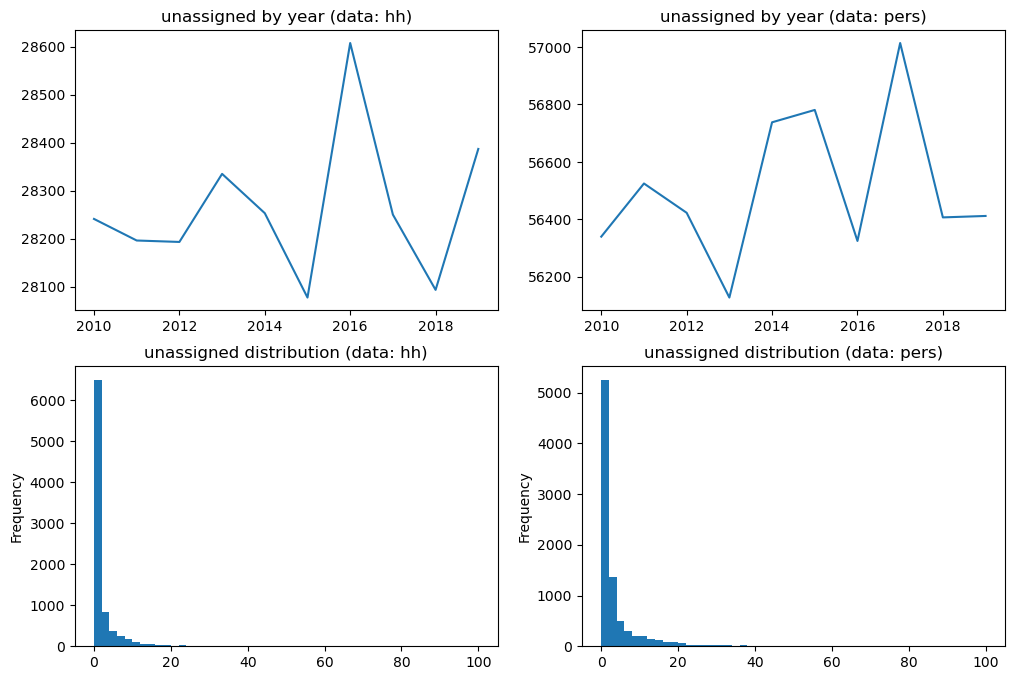

In [44]:
f,ax = plt.subplots(2,2,figsize=(12,8))

for i, label in enumerate(['hh', 'pers']):
    pop_data = pd.read_hdf('data/parsed/KN100m_pop.hdf', key=label)
    pop_unassigned_years = pop_data[~pop_data[cell_label].isin(is_assigned)][years].fillna(0)
    pop_unassigned_years.sum(axis=0).plot(ax=ax[0][i], title=f'unassigned by year (data: {label})')
    
    pop_unassigned = pop_data[~pop_data[cell_label].isin(is_assigned)][years].fillna(0).mean(axis=1)
    pop_unassigned.plot.hist(bins=50,range=[0,100], ax=ax[1][i], title=f'unassigned distribution (data: {label})')
    
    largest = pop_data[~pop_data[cell_label].isin(is_assigned)].set_index('DDKNm100').min(1).nlargest(5)
    
    print(label)
    print(largest)
    print('\n')
    